We need to create some data that isn't plates so that the CNN recognice if it's either catputing plates or not, and what exactly counts as a plate.

In [26]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
import cv2
import os

In [27]:
import pandas as pd
import json
import urllib
from PIL import Image
url='Indian_Number_plates.json'
data = pd.read_json('Indian_Number_plates.json', lines=True)
pd.set_option('display.max_colwidth', -1)
# Se borra la columna extra 
del data['extras']

# Se extraen los puntos con las cajas de la placa
data['points'] = data.apply(lambda row: row['annotation'][0]['points'], axis=1)

#se borra el resto de los datos
del data['annotation']
data.head()





,content,points
0,http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/77d1f81a-bee6-487c-aff2-0efa31a9925c____bd7f7862-d727-11e7-ad30-e18a56154311.jpg.jpeg,"[{'x': 0.722084367245657, 'y': 0.5879828326180251}, {'x': 0.8684863523573201, 'y': 0.688841201716738}]"
1,http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/4eb236a3-6547-4103-b46f-3756d21128a9___06-Sanjay-Dutt.jpg.jpeg,"[{'x': 0.16194331983805602, 'y': 0.850779510022271}, {'x': 0.582995951417004, 'y': 1}]"
2,http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/84969111-2ec3-4914-b3bb-da5aaac701e7___1.jpg.jpeg,"[{'x': 0.082, 'y': 0.697452229299363}, {'x': 0.23, 'y': 0.8280254777070061}]"
3,http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/52b45060-9645-47c7-882d-b69a5bf07eff___1006372d1351343820-my-new-maruti-swift-zxi-21102012241.jpg.jpeg,"[{'x': 0.434, 'y': 0.667377398720682}, {'x': 0.718, 'y': 0.7654584221748401}]"
4,http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/5d08ee4a-d8e7-4fda-8959-21f263f62c25___100923d1368191518-custom-number-plates-embossedplates1.jpg.jpeg,"[{'x': 0.20879120879120802, 'y': 0.39076376554174}, {'x': 0.865134865134865, 'y': 0.9840142095914741}]"


In [28]:
IMG_SIZE=128


Images = []


        
    
def downloadTraining(df):

    for index, row in df.iterrows():

        # Get the image from the URL
        resp = urllib.request.urlopen(row[0])
        im = np.array(Image.open(resp))
        # We append the image to the training input array
        Images.append(im)

downloadTraining(data)

In [29]:
training_data=[]
def imagesplitter(row,im,split,label):
        # Points of rectangle
        if label==0:
            
            x_point_top = row[1][0]['x']*im.shape[1]
            y_point_top = row[1][0]['y']*im.shape[0]
            x_point_bot = row[1][1]['x']*im.shape[1]
            y_point_bot = row[1][1]['y']*im.shape[0]

            # Cut the plate from the image and use it as output
            carImage = Image.fromarray(im)
            plateImage = carImage.crop((x_point_top, y_point_top, x_point_bot, y_point_bot))
        elif label==1:
            x_point_top = (row[1][0]['x']+0.1)*im.shape[1]
            y_point_top = (row[1][0]['y']+0.1)*im.shape[0]
            x_point_bot = (row[1][1]['x']+0.1)*im.shape[1]
            y_point_bot = (row[1][1]['y']+0.1)*im.shape[0]
            # Cut the plate from the image and use it as output
            carImage = Image.fromarray(im)
            plateImage = carImage.crop((x_point_top, y_point_top, x_point_bot, y_point_bot))
        else:
            label=1
            plateImage = Image.fromarray(im)

        new_plateImage=plateImage.resize((IMG_SIZE,IMG_SIZE))
        training_data.append([new_plateImage, label])  # add this to our training_data

In [30]:
index=0
for index, row in data.iterrows():        
    imagesplitter(row,Images[index],1,0) #add plate
    imagesplitter(row,Images[index],2,1) #add somthing that isnt a plate
    imagesplitter(row,Images[index],2,2) #add somthing that is really far away to recognize as plate
    index+=1

Let's see some data 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
fig, ax = plt.subplots(1, 1, constrained_layout=True)

# Set title
ax.set_title('Output Image')
print(len(training_data))
# Display the images
for item in training_data:
    fig, ax = plt.subplots(1, 1, constrained_layout=True)
    ax.imshow(item[0])
    plt.show()

In [31]:
#this is the amount of data we have
len(training_data)

711

We pass this to a format that would be received to our model conv layer

In [32]:
import random
import pickle
random.shuffle(training_data)
Features_output = []
Labels_output = []
for features,label in training_data:
    try:
        opencvImage = cv2.cvtColor(np.array(features), cv2.COLOR_RGB2BGR)    
        Features_output.append(opencvImage)
        Labels_output.append(label)
    except:
        print("Image input error, do not add to the format output") 



Features_output = np.array(Features_output).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

#we proceed to save the output 

pickle_out = open("Features_output.pickle","wb")
pickle.dump(Features_output, pickle_out)
pickle_out.close()

pickle_out = open("Labels_output.pickle","wb")
pickle.dump(Labels_output, pickle_out)
pickle_out.close()

Image input error, do not add to the format output
Image input error, do not add to the format output
Image input error, do not add to the format output


Lets start with some training

In [33]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

import pickle

pickle_in = open("Features_output.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("Labels_output.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0

model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#Export Model

checkpoint_path = "/home/alejandro/placas/cp.ckpt" 
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)

model.fit(X, y, batch_size=36, epochs=10, validation_split=0.3, callbacks= [cp_callback])

Train on 495 samples, validate on 213 samples
Epoch 1/10
468/495 [===========================>..] - ETA: 2s - loss: 2.5954 - acc: 0.6667
Epoch 00001: saving model to /home/alejandro/placas/cp.ckpt
495/495 [==============================] - 48s 96ms/sample - loss: 2.4775 - acc: 0.6747 - val_loss: 0.3914 - val_acc: 0.8451
Epoch 2/10
468/495 [===========================>..] - ETA: 2s - loss: 0.3901 - acc: 0.8462
Epoch 00002: saving model to /home/alejandro/placas/cp.ckpt
495/495 [==============================] - 49s 98ms/sample - loss: 0.3821 - acc: 0.8505 - val_loss: 0.3672 - val_acc: 0.8638
Epoch 3/10
468/495 [===========================>..] - ETA: 2s - loss: 0.3273 - acc: 0.8868
Epoch 00003: saving model to /home/alejandro/placas/cp.ckpt
495/495 [==============================] - 49s 99ms/sample - loss: 0.3177 - acc: 0.8909 - val_loss: 0.2974 - val_acc: 0.8826
Epoch 4/10
468/495 [===========================>..] - ETA: 2s - loss: 0.2038 - acc: 0.9402
Epoch 00004: saving model to /home/

Lets use our model with some new examples

(530, 795, 3)


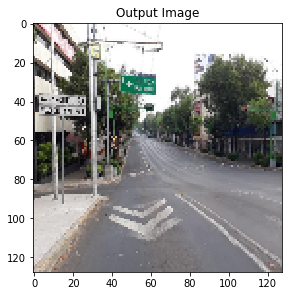

(512, 669, 3)


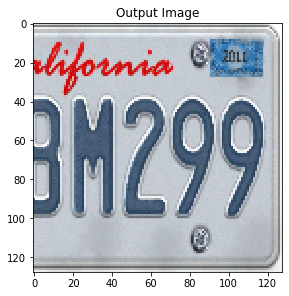

(216, 435, 3)


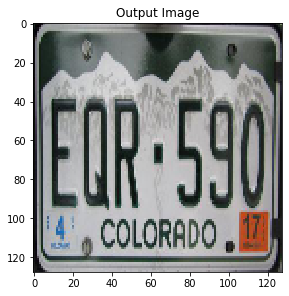

(852, 871, 3)


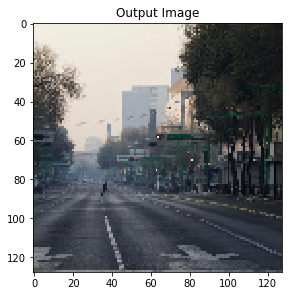

(530, 784, 3)


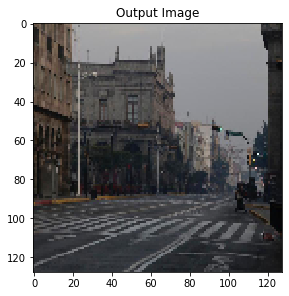

(524, 474, 3)


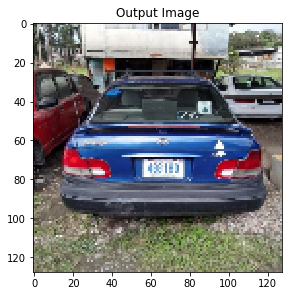

(960, 540, 3)


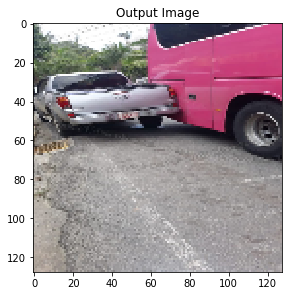

(183, 275, 3)


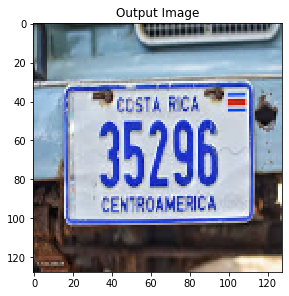

(169, 225, 3)


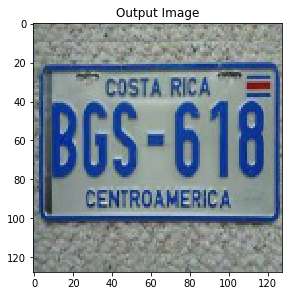

[[1.]]
[[0.]]
[[0.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.]]
[[0.]]


In [34]:
IMG_SIZE = 128 
def prepare(filepath):
    im = np.array(Image.open(filepath))
    print(im.shape)
    new_array = cv2.resize(im, (IMG_SIZE, IMG_SIZE))
    
    fig, ax = plt.subplots(1, 1, constrained_layout=True)

    # Set title
    ax.set_title('Output Image')

    # Display the images
    ax.imshow(new_array)

    plt.show()
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)


prediction = model.predict([prepare('/home/alejandro/placas/prueba1.jpg')])
prediction2 = model.predict([prepare('/home/alejandro/placas/prueba2.jpg')])
prediction3 = model.predict([prepare('/home/alejandro/placas/prueba3.jpg')])
prediction4 = model.predict([prepare('/home/alejandro/placas/prueba4.jpg')])
prediction5 = model.predict([prepare('/home/alejandro/placas/prueba5.jpg')])
prediction6 = model.predict([prepare('/home/alejandro/placas/prueba6.jpg')])
prediction7 = model.predict([prepare('/home/alejandro/placas/prueba7.jpg')])
prediction8 = model.predict([prepare('/home/alejandro/placas/prueba8.jpg')])
prediction9 = model.predict([prepare('/home/alejandro/placas/prueba9.jpg')])


print(prediction)
print(prediction2)
print(prediction3)
print(prediction4)
print(prediction5)
print(prediction6)
print(prediction7)
print(prediction8)
print(prediction9)

Seems our model has trouble if it captures half plates, all the other test seemed to provide good results